In [42]:
# ! pip install tensorflow numpy matplotlib opencv-python


In [43]:
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224,224))  # Set your desired size
    img = np.array(img) / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

content_image = load_and_preprocess_image('../data/profile-pic.png')
style_image = load_and_preprocess_image('../data/style2.jpg')


In [44]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19

model = VGG19(weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False  # Freeze the layers


In [45]:
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


In [46]:
# Create a model that outputs the desired layers
def get_model(output_layers):
    outputs = [model.get_layer(layer).output for layer in output_layers]
    return tf.keras.Model(inputs=model.input, outputs=outputs)

# Create a model for content and style
content_model = get_model([content_layer])
style_model = get_model(style_layers)


In [47]:
def get_features(model, image):
    # Forward pass through the model to get the features
    features = model(image)
    return features

# Get content and style features
content_features = get_features(content_model, content_image)
style_features = get_features(style_model, style_image)


In [48]:
def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))


In [49]:
def gram_matrix(tensor):
    # Calculate the Gram matrix for style representation
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    return tf.matmul(tf.transpose(a), a)

def style_loss(style, generated):
    style_gram = gram_matrix(style)
    generated_gram = gram_matrix(generated)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))


In [50]:
for i in range(10):
    with tf.GradientTape() as tape:
        # Get features of the generated image using both content and style models
        generated_content_features = get_features(content_model, generated_image)
        generated_style_features = get_features(style_model, generated_image)

        # Compute content and style loss
        c_loss = content_loss(content_features[0], generated_content_features[0])
        s_loss = sum(style_loss(style_features[j], generated_style_features[j]) for j in range(len(style_layers)))

        total_loss = content_weight * c_loss + style_weight * s_loss

    grads = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(grads, generated_image)])


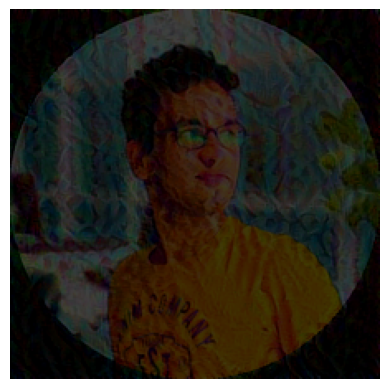

In [56]:
# After the optimization loop
# Convert the final output back to an image format
output_image = generated_image.numpy().squeeze()  # Remove batch dimension
output_image = np.clip(output_image * 64, 0, 64).astype('uint8')  # Scale back to [0, 255]

# Display the output image
import matplotlib.pyplot as plt

plt.imshow(output_image)
plt.axis('off')  # Hide axis
plt.show()
